<a href="https://www.kaggle.com/code/danielzaslavsky/data-exploration-visualization-basic-analytics?scriptVersionId=162223666" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import the required modules

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, f_classif, chi2, SelectKBest, SelectFpr
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support




# Load the time-series data and lookt at the features statistics

In [2]:
ts_data = pd.read_csv("/kaggle/input/hdd-data/ts_data.csv")
print(ts_data.shape)
ts_data.head()

(204000, 9)


,d_id,time,bb_count,r-w_rate,reconsects_count,recovbydrv_count,xfer_rate,bb_diffs,fail
0,1,V1,-5,14,0,9,85,0,True
1,1,V2,5,15,0,17,76,0,True
2,1,V3,14,11,0,24,87,0,True
3,1,V4,22,7,0,31,75,0,True
4,1,V5,29,11,0,42,81,0,True


In [3]:
ts_data.groupby('fail').describe()

d_id                                                        \
          count    mean          std    min      25%     50%      75%   
fail                                                                    
False  200000.0  5200.5  2886.758548  201.0  2700.75  5200.5  7700.25   
True     4000.0   100.5    57.741523    1.0    50.75   100.5   150.25   

                bb_count              ... xfer_rate         bb_diffs           \
           max     count        mean  ...       75%    max     count     mean   
fail                                  ...                                       
False  10200.0  200000.0   97.986965  ...      83.0  148.0  200000.0  3.01709   
True     200.0    4000.0  122.358000  ...     104.0  145.0    4000.0  1.04475   

                                           
            std  min  25%  50%  75%   max  
fail                                       
False  2.466513  0.0  1.0  3.0  4.0  22.0  
True   1.390227  0.0  0.0  0.0  2.0   9.0  

[2 rows x 56 columns]

# Plot the time series data

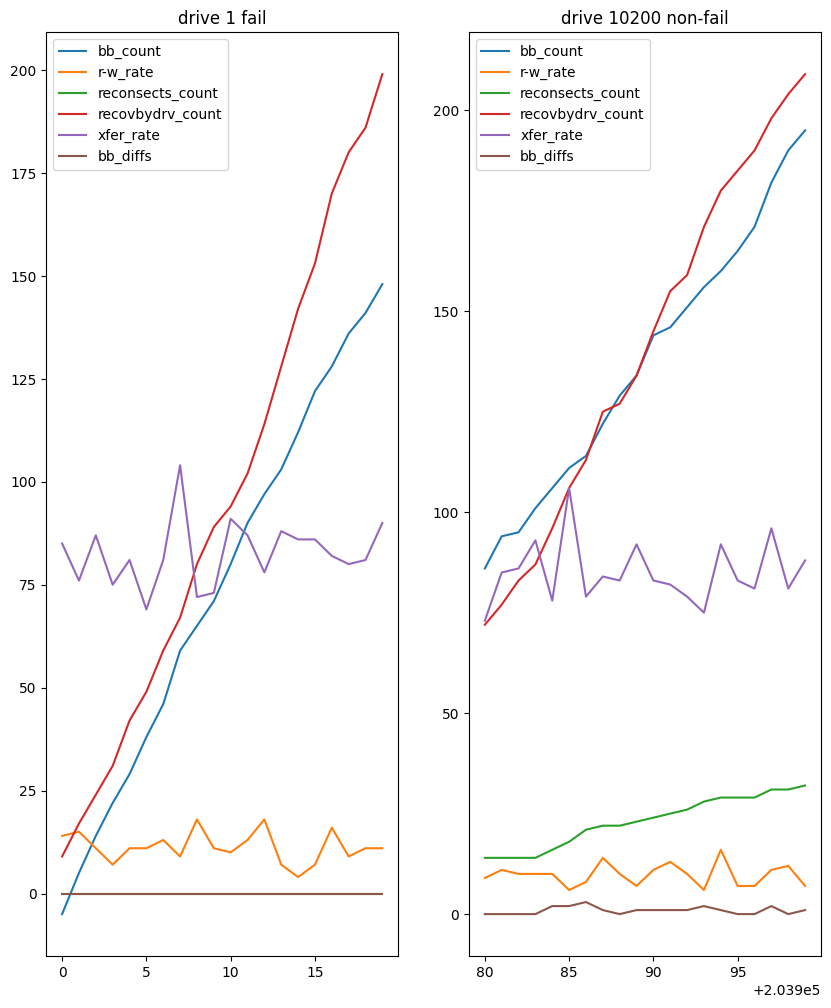

In [4]:
original_features = ['bb_count', 'r-w_rate', 'reconsects_count',
       'recovbydrv_count', 'xfer_rate', 'bb_diffs']

fig, axes = plt.subplots(nrows=1, ncols=2)

ts_data.loc[ts_data['d_id']==1,original_features].plot(figsize=(10,12), title='drive '+str(1)+' fail', ax=axes[0])

num_drives = ts_data['d_id'].unique().shape[0]
#num_drives

ts_data.loc[ts_data['d_id']==num_drives,original_features].plot(figsize=(10,12), title='drive '+str(num_drives)+' non-fail', ax=axes[1])
plt.legend()

# Engineer the time-series features

For each Create the aggregated features (mean, median, variance, minimum and naximum):
* for each sn
* for each feature
* for each aggregation type
        aggregate the 20 daily samples into one aggregated sample  

In [5]:
aggregations = {
    'bb_count': ['mean', 'median', 'var', 'min', 'max'],
    'r-w_rate': ['mean', 'median', 'var', 'min', 'max'],
    'reconsects_count': ['mean', 'median', 'var', 'min', 'max'],
    'recovbydrv_count': ['mean', 'median', 'var', 'min', 'max'],
    'xfer_rate': ['mean', 'median', 'var', 'min', 'max'],
    'bb_diffs': ['mean', 'median', 'var', 'min', 'max']
}

# groups by the above aggregations. 
"""
Here are some explanations that I researched for the more confusing parts of this line:
df.groupby('d_id'): This groups the DataFrame by the "d_id" column. This creates groups for each unique d_id value.
.agg(aggregations): This applies the aggregations specified in the "aggregations" dictionary to each group. Each key in the dictionary is a column name, and its value is a list of aggregation functions to apply. For example, for the "bb_count" column, it will calculate the mean, median, variance, minimum, and maximum.
.reset_index(): This converts the grouped DataFrame back to a regular DataFrame. Now, each row represents a unique combination of d_id and statistic (e.g., d_id 1 with mean bb_count, d_id 1 with median bb_count, etc.).

"""
result = ts_data.groupby('d_id').agg(aggregations).reset_index()
# Changed names of columns to fit the requirnments.
result.columns = [col[0] if col[1] == '' else f'{col[0]}_{col[1]}' for col in result.columns]

# In general, doing it like so is 10 times easier then creating each and every feature into a different dataframe and then merging them. 
# Doing that is far more dangerous then just using built-in aggregations functions.

In [6]:
conf_data = pd.read_csv("/kaggle/input/hdd-data/conf_data.csv")
conf_data.head()

,d_id,age,capacity,model,fail
0,1,15,1TB,Hitachi,True
1,2,23,1TB,Fujitsu,True
2,3,23,1TB,Seagate,True
3,4,14,1TB,Hitachi,True
4,5,18,600GB,Hitachi,True


# Look at the features\labels distribution

<Axes: title={'center': 'age'}, xlabel='[fail]'>

<Figure size 640x480 with 0 Axes>

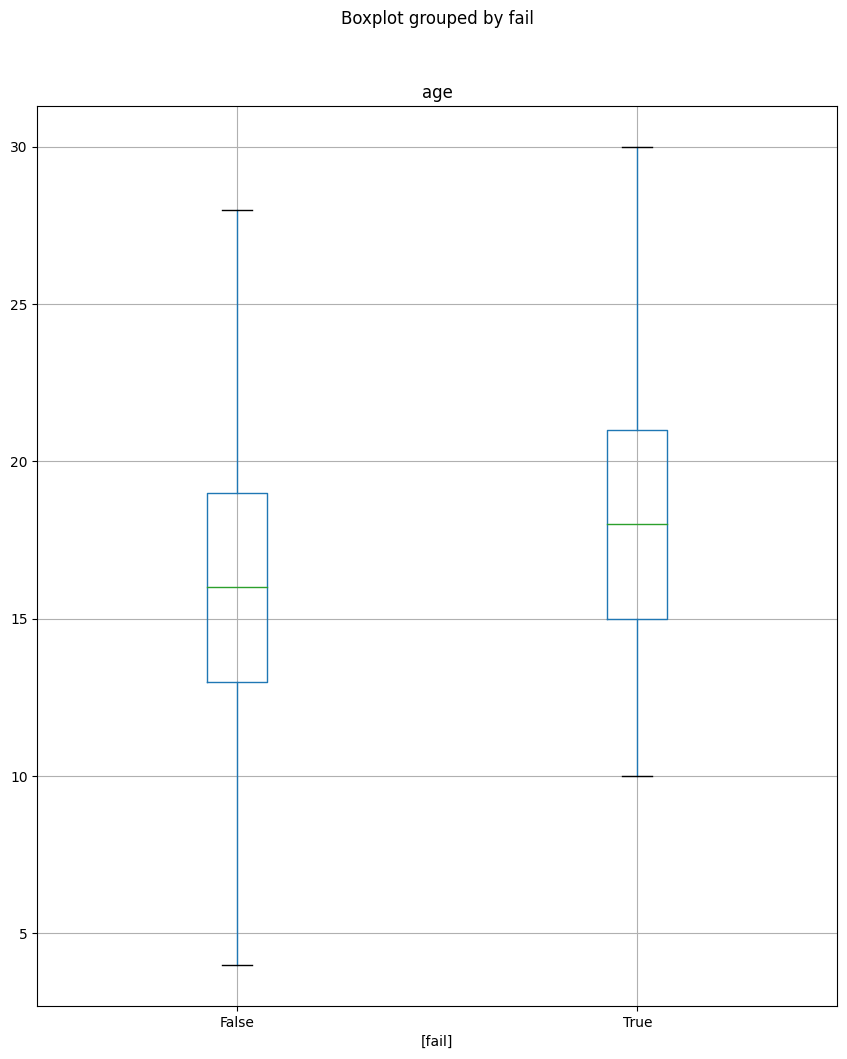

In [7]:
plt.figure()
conf_data[['age', 'fail']].boxplot(by='fail', figsize=(10,12), sym='')

<Axes: xlabel='model'>

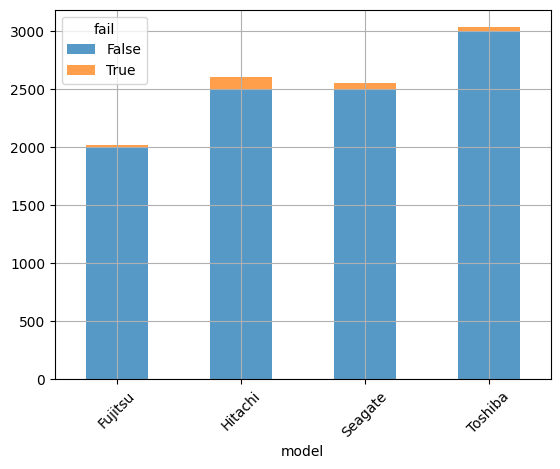

In [8]:
g = conf_data.groupby(["model", "fail"])['d_id'].count().unstack('fail')
g.plot(kind="bar", stacked=True, grid=True, alpha=0.75, rot=45)

# Handle categorical data 

For the decision tree algorithm, map the categorical features to numeric with:
* "Change_capacity" function for "capacity" column
* "pd.get_dummies" function for "model" column


In [9]:
def change_capacity(data):
    # A function that receives a data frame and a column name as input and map the categorical capacity feature to numeric 
    di = dict(zip(conf_data["capacity"].unique(), [1000, 600, 300]))

    return data.replace({"capacity": di}, inplace=False)
# Fixed and added return

In [10]:
new_conf_data = change_capacity(conf_data)

new_conf_data = new_conf_data.join(pd.get_dummies(new_conf_data["model"]))
new_conf_data.drop("model", axis=1, inplace=True)

# Merge the aggregated time-series and the configuration datasets

In [11]:
merged_data = pd.merge(result, new_conf_data, on="d_id", how="left")
# Dropping d_id as suggested by the work sheet
merged_data.drop("d_id", axis=1, inplace=True)

# Select the 10 most informative features and transform the data

In [12]:
"""
Decided, for now, to go with Mutual information,
just like we learned in statistics.
Luckily  there is already a comfortable way to do that with sklearn :)
"""
from sklearn.feature_selection import mutual_info_classif as mic

# Creating a list of features and removing the target variable (fail)
features = list(merged_data.columns)
features.remove("fail")
target = "fail"

# Calculate MI scores
mi_scores = mic(merged_data[features], merged_data[target])

# transform into dataframe
mi_df = pd.Series(mi_scores, index=features)

# Now, sort values of MI scores. the higher, the better.
# Sort features by mutual information score in descending order
top_10_features = mi_df.sort_values(ascending=False).head(10).index.tolist()

for i in top_10_features:
    print(i)

xfer_rate_mean
xfer_rate_median
xfer_rate_max
xfer_rate_min
reconsects_count_min
reconsects_count_mean
reconsects_count_median
reconsects_count_max
r-w_rate_median
r-w_rate_mean


# Train a Decision tree classifier 

Since we are learning and testing on the same set we will limit the maximum depth parameter to 5 to prevent overfitting

In [13]:
X = merged_data[top_10_features]  # our new features
y = merged_data["fail"]  # our target variable

dtree = DecisionTreeClassifier(max_depth=5)
dtree.fit(X, y)

DecisionTreeClassifier(max_depth=5)

# Make the prediction and plot the confusion matrix
https://en.wikipedia.org/wiki/Confusion_matrix

* Change "max_depth" paramter to see what happens to model results (present the the results of 2-3 diffrent max configurations)
* Based on confusiotn matrix  result of the orginal max_depth = 5 configuration, caluclate (manualy) the Precision, Recall and False Positive Rate measures - presen the your calclaiton as notes in the notebook  


In [14]:
y_pred = dtree.predict(X) # The general prediction
cm = confusion_matrix(y, y_pred) # Make a nice comfy confusion matrix, showing a 
"""
[[TN, FP],
 [FN, TP]]
 kind of form.
 Which for comfortable calculations, we will output as...
"""
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

# And now we will copy someone who made the print much prettier and nicer :)
print("Confusion Matrix:")
print(" "*5, "Predicted Fail", "Predicted Not Fail")
print("Actual Fail", f"| TN={TN:>3} | FP={FP:>3} |")
print("Actual Not Fail", f"| FN={FN:>3} | TP={TP:>3} |")
accuracy = accuracy_score(y, y_pred) 
precision = precision = TP / (TP + FP) 
recall = TP / (TP + FN)
false_positive_rate = FP / (FP + TN)

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"False Positive Rate: {false_positive_rate:.3f}")

Confusion Matrix:
      Predicted Fail Predicted Not Fail
Actual Fail | TN=9979 | FP= 21 |
Actual Not Fail | FN= 48 | TP=152 |

Additional Metrics:
Accuracy: 0.993
Precision: 0.879
Recall: 0.760
False Positive Rate: 0.002


The results for-
max depth = 2:

 TN=9991 | FP=  9 |
| FN=129 | TP= 71 |

Accuracy: 0.986
Precision: 0.887
Recall: 0.355
False Positive Rate: 0.001

max depth = 5:


TN=9979 | FP= 21 |
FN= 48 | TP=152 |

Accuracy: 0.993
Precision: 0.879
Recall: 0.760
False Positive Rate: 0.002

max depth = 10

TN=9999 | FP=  1 |
| FN=  7 | TP=193 |

Accuracy: 0.999
Precision: 0.995
Recall: 0.960
False Positive Rate: 0.000



As we can see through the given metrics, changing the max depth in the current situation, doesn't change them by much. The accuracy ever so slightly increases with higher depths, but the degree is so little (and considering we used the same dataset for both testing AND training) that it matters very little.
The higher we set max depth, the more specific the information we use is to the dataset which works, in this case, because the train IS the test, but it would not work in another setting

In [15]:
# Describe what is the major problem with the trained model, suggest a way to fix it (no need to implement it)

The main issue is that we used the same dataset, without splitting it first, to both train AND test itself. An easy
fix would be to simply divide it into 0.2/0.8 ratio (or some other similar ratio) and THEN proparly test it.
Basically, overfitting due to no splitting.

In [16]:
# Suggest a way to improve the model (no need to implement it)

Other then the obvious test/split problem, we can improve the model by adding more information or alternatively, we could use two seperate databses in order to optimally avoid overfitting.